<a href="https://colab.research.google.com/github/deerow22/EscapeEarth/blob/main/project-EE/TICID_190885165.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## typical imports
%matplotlib inline
!pip install lightkurve==1.9.0 #b/c non-standard library & we want a specific version
import lightkurve as lk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#find available data
search_result = lk.search_lightcurvefile('TIC 190885165')
search_result

#,observation,target_name,productFilename,distance
0,TESS Sector 15,190885165,tess2019226182529-s0015-0000000190885165-0151-s_lc.fits,0.0
1,TESS Sector 16,190885165,tess2019253231442-s0016-0000000190885165-0152-s_lc.fits,0.0


In [ ]:
#download all data available
lc_files = search_result.download_all()
lc_files

LightCurveFileCollection of 2 objects:
	TIC 190885165 (2 TessLightCurveFiles) Sectors: 15,16

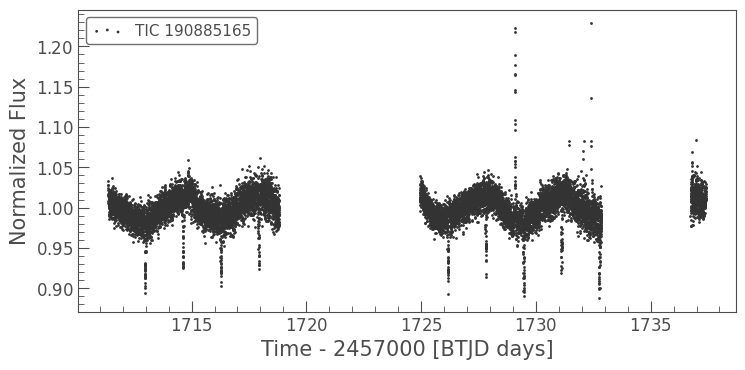

In [ ]:
#clean & visualize data

lc = lc_files[0].PDCSAP_FLUX.normalize() #select first file, select detrended flux, normalize #NOTE: if only one file available try removing [0] b/c it will cause an error
lcflat=lc.flatten() #flatten rotational modulations
lc_gtg = lcflat.remove_nans() #remove nans from data gaps
#NOTE: we skipped the remove outliers step to avoid cutting off transit bottoms 

lc.scatter(); #plot light curve before flattening (ie theres still rotational modulations in the data)

In [ ]:
#functions from our LCAnalysis

def periods(N=1000):
    period=np.logspace(-0.523, 1.43, N, endpoint=True)
    return period

def duration_grid(N=3):
    duration=np.linspace(.01, 0.298, N)
    return duration
    
def BLS(periodgrid,lightcurve,flat_time,durationgrid):
    from astropy.timeseries import BoxLeastSquares

    '''
    Purppose
    ------------------
    A Box Least Squares function to print out the compute stats of the periodogram.
    Parameters
    -------------------
    period grid            - describes how often the transit is happening (arrays different value)
    duration grid          - describes the width of the transit (array of different values)
    lightcurve             - lightkurve class object
    Returns
    list of stats in the following order: period, duration, transit-time, power, depth
    ------------------
    Calculate several statistics of a candidate transit.
    '''
    #assigning parameters to variables
    period = periodgrid
    duration = durationgrid
    lc = lightcurve

    t = flat_time #time
    y = lc.flux #flux

    #dy is the uncertianty
    model = BoxLeastSquares(t, y, dy= lc.flux_err)
    periodogram = model.power(period,duration)
    max_power = np.argmax(periodogram.power)

    #calculates the max stats w/in the transit
    stats = [periodogram.period[max_power],
            periodogram.duration[max_power],
            periodogram.transit_time[max_power],
            max_power,
            periodogram.depth[max_power],
            periodogram.period,periodogram.power,periodogram.transit_time]

    #stats is the one peak, periodogram is the array
    return stats




In [ ]:
#run BLS

##to use defaults
#pg = periods()
#dg = duration_grid()

## OR customize period & duration grids
pg = np.linspace(1.2,2, 10000) 
 # change 1st & 2nd values to change startpoint & endpoint of list of periods to check

dg = np.linspace(.03,0.04, 10000) # change same as for period grid

#run BLS
bls_output = BLS(pg, lc_gtg, lc_gtg.time, dg)
bls_output[0:5] #period, duration, transit_time, power, depth  <---meaning of order of output values

[1.6489248924892488, 0.033, 1712.977742075276, 5611, 0.0418121337921023]

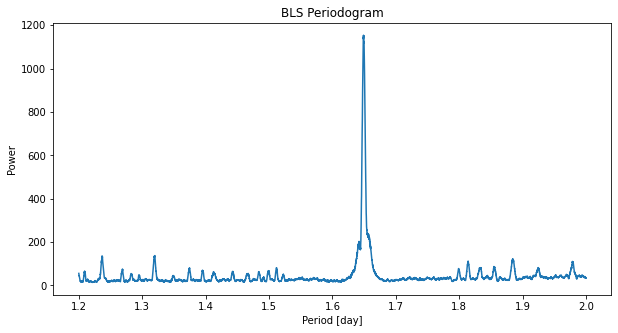

In [ ]:
#plot the periodogram

plt.figure(figsize=(10,5))
plt.plot(bls_output[5],bls_output[6]) #x-axis = periods checked, y-axis = strength of model fit at period checked
plt.xlabel('Period [day]')
plt.ylabel('Power') 
plt.title('BLS Periodogram');


#highest peak is the best fit orbital period, any other peaks should appear at multiples of the best peak OR could be more planets!

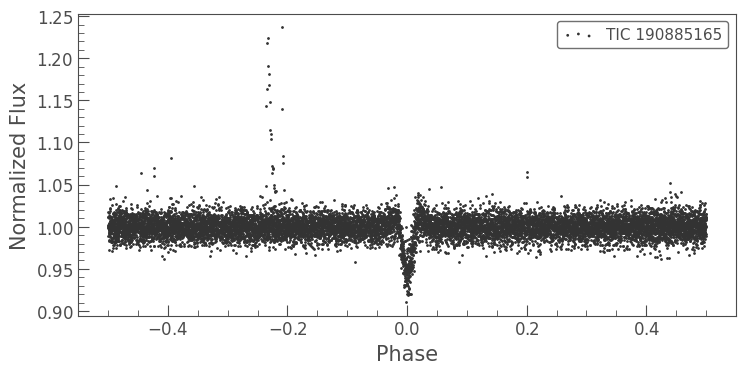

In [ ]:
        #plot folded light curve

#fold lc
lcfold = lc_gtg.fold(bls_output[0],t0=bls_output[2]) #inputs are best fit model's (period value, transit_time) 
#the transit time helps center the transit in the folded plot

lcfold.scatter() #actual plot


In [ ]:
from astroquery.mast import Catalogs
catalog_data = Catalogs.query_criteria(catalog='Tic',ID=190885165)
catalog_df = catalog_data.to_pandas() 

In [ ]:
catalog_df['Depth']= bls_output[4]

In [ ]:
catalog_df

,ID,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,KIC,objType,typeSrc,ra,dec,POSflag,pmRA,e_pmRA,pmDEC,e_pmDEC,PMflag,plx,e_plx,PARflag,gallong,gallat,eclong,eclat,Bmag,e_Bmag,Vmag,e_Vmag,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,...,duplicate_id,priority,eneg_EBV,epos_EBV,EBVflag,eneg_Mass,epos_Mass,eneg_Rad,epos_Rad,eneg_rho,epos_rho,eneg_logg,epos_logg,eneg_lum,epos_lum,eneg_dist,epos_dist,distflag,eneg_Teff,epos_Teff,TeffFlag,gaiabp,e_gaiabp,gaiarp,e_gaiarp,gaiaqflag,starchareFlag,VmagFlag,BmagFlag,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,objID,Depth
0,190885165,20190415,<NA>,NaN,661-102843,21442066+4211363,NaN,NaN,1972599455956632448,51912452,<NA>,STAR,tmgaia2,326.086202,42.193482,tmgaia2,165.65,0.10185,247.247,0.107431,gaia2,11.5659,0.068562,gaia2,89.863771,-8.3571,349.667228,51.319546,NaN,NaN,16.55,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.001076,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5109,0.5169,bj2018,NaN,NaN,cdwrf,16.3792,0.007808,13.3906,0.002283,1,NaN,cdwrf,NaN,cooldwarfs_v8,1.692742,1.666047,326.087165,42.194547,0.046779,0.053716,1,0,459572894,0.041812


In [ ]:
def planet_radii(depth, star_radius):
    import math as m
    R_Sun = 696340000 #m
    R_Earth = 6371000 #m
    r_star = star_radius * R_Sun #b/c in R_Sun units
    radius = r_star * m.sqrt(depth) 
    r_planet = radius / R_Earth #b/c need in R_Earth
    return r_planet

In [ ]:
PLANET = catalog_df['Depth'].to_numpy() #transit's depth
STAR = catalog_df['rad'].to_numpy() #star's radius
NAMES = catalog_df['ID'].to_numpy() #star id

radii = [] #empty list to hold results
for i,j in zip(PLANET,STAR):
  starr = planet_radii(i, j) #apply function
  radii.append(starr) #capture all results
  print("Estimared exoplanet radius:", starr, "Earth radii") #print out results

Estimared exoplanet radius: 9.979655415880872 Earth radii
